# Exploratory data analysis on delays of Getaround data
Let's dive into given data to figure out
*    how complete dataset is
*    what are the feature (column) distributions like
*    identifying any outliers
*    impact of features on rental cancellation
*    adressing delay threshold between two rentals
*    adressing whether to enable the feature for all cars? or to use only with Connect cars?



## Setup libraries and data

In [259]:
os.chdir('..//data') #neccessary for read_excel
f_delay= 'get_around_delay_analysis.xlsx'
dataset= pd.read_excel(io= f_delay, sheet_name = 'rentals_data')
dataset.head(5)

,rental_id,car_id,checkin_type,state,delay_at_checkout_in_minutes,previous_ended_rental_id,time_delta_with_previous_rental_in_minutes
0,505000.0,363965.0,mobile,canceled,NaN,NaN,NaN
1,507750.0,269550.0,mobile,ended,-81.0,NaN,NaN
2,508131.0,359049.0,connect,ended,70.0,NaN,NaN
3,508865.0,299063.0,connect,canceled,NaN,NaN,NaN
4,511440.0,313932.0,mobile,ended,NaN,NaN,NaN


*Information given on columns in delay data*


* rental_id	Unique identifier of the rental
* car_id	Unique identifier of the car
* checkin_type	"Flow used for both checkin and checkout. (ie. access and return the car)
* mobile = rental agreement signed on the owner's smartphone
* connect = car equiped with the Connect technology , opened by the driver with his smartphone.
Note: paper contracts were excluded from the data as we have no data on their delay at checkout and it's negligible use case"
* state	canceled means that the rental did not happen (was canceled by the driver or the owner).
* delay_at_checkout_in_minutes	Difference in minutes between the rental end time requested by the driver when booking the car and the actual time the driver completed the checkout. Negative values mean that the driver returned the car in advance.
* previous_ended_rental_id	id of the previous ended rental of the car (NULL when no *previous rental or delay with previous rental higher than 12 hours)
* time_delta_with_previous_rental_in_minutes	Difference in minutes between this rental planned start time and the previous rental planned end time (when lower than 12 hours, NULL if higher)


In [260]:
dataset.columns

Index(['rental_id', 'car_id', 'checkin_type', 'state',
       'delay_at_checkout_in_minutes', 'previous_ended_rental_id',
       'time_delta_with_previous_rental_in_minutes'],
      dtype='object')

## Any missing data? 

Any missing data? Data distribution?

In [261]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21310 entries, 0 to 21309
Data columns (total 7 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   rental_id                                   21310 non-null  float64
 1   car_id                                      21310 non-null  float64
 2   checkin_type                                21310 non-null  object 
 3   state                                       21310 non-null  object 
 4   delay_at_checkout_in_minutes                16346 non-null  float64
 5   previous_ended_rental_id                    1841 non-null   float64
 6   time_delta_with_previous_rental_in_minutes  1841 non-null   float64
dtypes: float64(5), object(2)
memory usage: 1.1+ MB


In [262]:
cols_cat  = [ 'car_id', 'checkin_type',
             'state' ]

cols_num = ['time_delta_with_previous_rental_in_minutes',
            'delay_at_checkout_in_minutes']

## Distribution of categorical features

In [263]:
dataset[cols_cat[0]].value_counts(dropna=False)

334190.0    33
392479.0    29
241021.0    29
342699.0    27
300505.0    24
            ..
372160.0     1
297623.0     1
403246.0     1
267750.0     1
408598.0     1
Name: car_id, Length: 8143, dtype: int64

In [264]:
dataset[cols_cat[1]].value_counts(dropna=False)

mobile     17003
connect     4307
Name: checkin_type, dtype: int64

In [265]:
dataset[cols_cat[2]].value_counts(dropna=False)

ended       18045
canceled     3265
Name: state, dtype: int64

## Distribution of numerical features


Description of data distribution

count    1841.000000
mean      279.288430
std       254.594486
min         0.000000
25%        60.000000
50%       180.000000
75%       540.000000
max       720.000000
Name: time_delta_with_previous_rental_in_minutes, dtype: float64

Plotted distribution



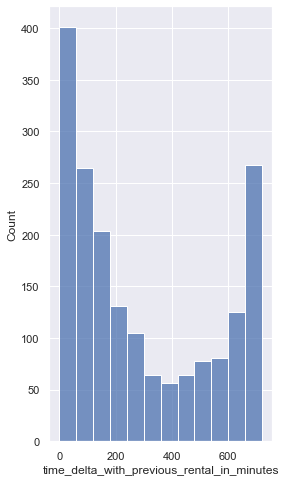

In [266]:
print('\nDescription of data distribution\n')
print(dataset[cols_num[0]].describe())
print('\nPlotted distribution\n')
sns.histplot(dataset, x= cols_num[0])
plt.show()


Description of data distribution

count    16346.000000
mean        59.701517
std       1002.561635
min     -22433.000000
25%        -36.000000
50%          9.000000
75%         67.000000
max      71084.000000
Name: delay_at_checkout_in_minutes, dtype: float64

Plotted distribution



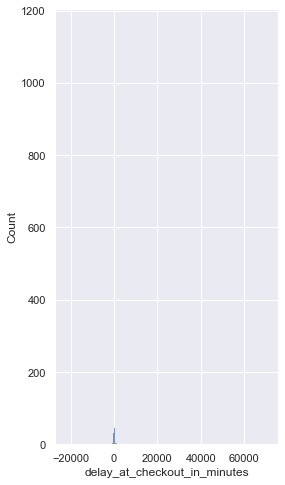

In [267]:
print('\nDescription of data distribution\n')
print(dataset[cols_num[1]].describe())
print('\nPlotted distribution\n')
sns.histplot(dataset, x= cols_num[1])
plt.show()


Description of data distribution

count    15457.000000
mean        14.359319
std        130.420117
min       -599.000000
25%        -35.000000
50%          8.000000
75%         59.000000
max        597.000000
Name: delay_at_checkout_in_minutes, dtype: float64

Plotted distribution



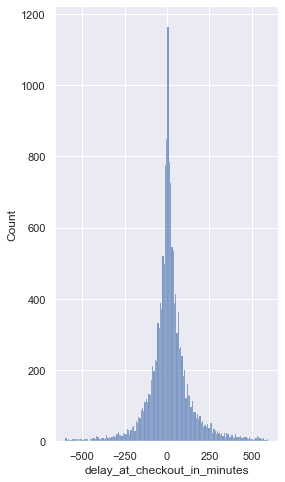

In [268]:
#let's concentrate on central values
mask_late = dataset[cols_num[1]] < 600. #10 hour
mask_early = dataset[cols_num[1]] > -600. #10 hour
print('\nDescription of data distribution\n')
print(dataset.loc[mask_late&mask_early,cols_num[1]].describe())
print('\nPlotted distribution\n')
sns.histplot(dataset.loc[mask_late&mask_early,:], x= cols_num[1])
plt.show()

Let's create a new column whether rental was *not_delayed, delayed, very_delayed, extremely_delayed and not_applicable*

In [288]:
def delay_re (x):
    if x < 0 :
        y = '0- No delay'
    elif x < 10 : 
        y = '1- Delay < 10 mins'
    elif x < 60 :
        y = '2- 10 ≤ Delay < 60 mins'
    elif x >= 60 :
        y = '3- Delay ≥ 60'
    else:
        y = '4- Not applicable'
    return y

dataset['delay'] = dataset.delay_at_checkout_in_minutes.apply(lambda x: delay_re(x))

dataset = dataset.sort_values('delay')


Description of data distribution

0- No delay                6820
4- Not applicable          4964
3- Delay ≥ 60              4428
2- 10 ≤ Delay < 60 mins    3685
1- Delay < 10 mins         1413
Name: delay, dtype: int64

Plotted distribution



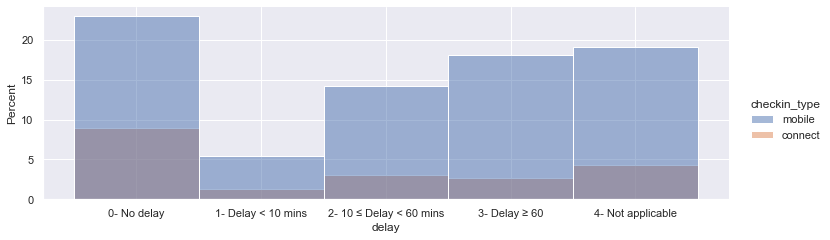

In [290]:
print('\nDescription of data distribution\n')
print(dataset['delay'].value_counts())
print('\nPlotted distribution\n')
sns.displot(dataset, x= 'delay',stat='percent',
            hue='checkin_type',  height=3.5, aspect=3.)
plt.show()


## Outliers ?

Let's define a strategy to limit adverse effects of possible outliers.

Let's remove nan rows in delay.

**Categorical columns**
* nothing special to do

**Numerical columns**
* let's take central 98% of data for the columns of "delay_at_checkout_in_minutes"

In [291]:
col_ = 'delay_at_checkout_in_minutes'
mask1 = dataset[col_ ] <= dataset[col_].quantile(0.01)
mask2 = dataset[col_ ] >= dataset[col_ ].quantile(0.99)
print('Taking central 98% data\n')
dataset2= dataset.loc[~ (mask1 | mask2),:]

print('Done\n')
print('\nShape of new dataset:', dataset2.shape)
print('\nShape of previous dataset:', dataset.shape)
print('\nAmount of rows trimmed from first dataset: ', dataset.shape[0] - dataset2.shape[0])


Taking central 98% data

Done


Shape of new dataset: (20980, 8)

Shape of previous dataset: (21310, 8)

Amount of rows trimmed from first dataset:  330



Description of data distribution after removing possible outliers

count    16016.000000
mean        31.765297
std        214.883059
min       -852.000000
25%        -35.000000
50%          9.000000
75%         65.000000
max       1490.000000
Name: delay_at_checkout_in_minutes, dtype: float64

Plotted distribution after removing possible outliers



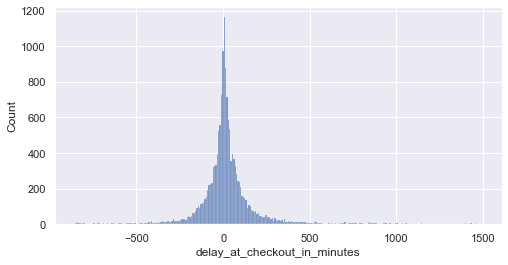

In [292]:
print('\nDescription of data distribution after removing possible outliers\n')
print(dataset2[col_].describe())
print('\nPlotted distribution after removing possible outliers\n')
plt.figure(figsize=(8,4))
sns.histplot(dataset2, x= col_)
plt.show()


Plotted distribution of delays in minutes (larger than 0, less than 500 mins)



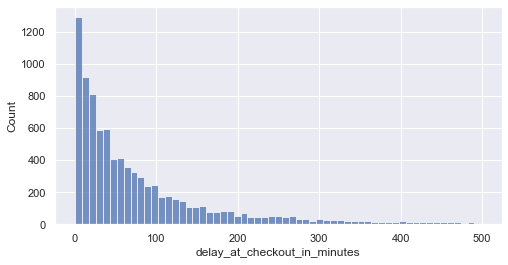

In [293]:
mask_a = dataset2 [col_] > 0.0
mask_b = dataset2 [col_] < 500.0
print('\nPlotted distribution of delays in minutes (larger than 0, less than 500 mins)\n')
plt.figure(figsize=(8,4))
sns.histplot(dataset2.loc[mask_a&mask_b,:], x= col_)
plt.show()



**Discussion**

It is bizzare to see delays more than 1 hour. Appearently, the users waited about an hour to have the car ready. It goes even more than a day. It makes me question about its sources. I would 

*  ask data engineers in my company to check their calculations of delay at checkout and 
*  then, if all is correct, contact managers to start a parallel project on the motivation of users waiting more than an hour. What made them motivated to wait for the car. Were they sure that the vehicle will be available after such long wait?

I would also suggest managers to start a campaign to offer either 'money back' to long-awaited users or even 'free ride' while ensuring no delay next time.

## Correspondance matrix

Let's find out the correlation between features and target column

In [294]:
dataset2.state.value_counts()

ended       17716
canceled     3264
Name: state, dtype: int64

In [295]:
#df.corr() function works for numeric columns. So non numerical columns will be factorized below.
for col in dataset2.columns:
    if dataset2[col].dtype == object :
        dataset2.loc[:, 'factorized_'+col] =pd.factorize(dataset2[col])[0]

dataset2.iloc[:,-3:].head(3)

C:\Users\lisbi\AppData\Local\Temp\ipykernel_15236\80272423.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\lisbi\AppData\Local\Temp\ipykernel_15236\80272423.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\lisbi\AppData\Local\Temp\ipykernel_15236\80272423.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs

,factorized_checkin_type,factorized_state,factorized_delay
10200,0,0,0
16156,1,0,0
16159,0,0,0


In [296]:
print('\nTop features corresponding to factorized_state')
corr_match=dataset2.corr().loc[:,['delay_at_checkout_in_minutes']].abs().sort_values(by='delay_at_checkout_in_minutes',ascending=False)
corr_match.head(20)


Top features corresponding to factorized_state


,delay_at_checkout_in_minutes
delay_at_checkout_in_minutes,1.000000
factorized_delay,0.607645
factorized_checkin_type,0.145974
time_delta_with_previous_rental_in_minutes,0.039229
car_id,0.003042
previous_ended_rental_id,0.002282
rental_id,0.000604
factorized_state,NaN


**Discussion**

Delay at checkout is correlated to check-in type. 
Time_delta_with_previous_rental does not seem to have a collinearity, ignoring IDs. 

## Finding a threshold?

In [297]:
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio

In [298]:
fig = px.histogram(dataset2, x='state', color = 'delay')
fig.show()

In [299]:
fig = px.histogram(dataset2, x='state', color = 'delay',
           facet_col= 'checkin_type')
fig.show()

In [300]:
fig = px.histogram(dataset2, facet_col='checkin_type', 
                   x='delay_at_checkout_in_minutes',
                   marginal='box', nbins=25 )
fig.show()

In [301]:
fig = px.box(dataset2, x='state', y='time_delta_with_previous_rental_in_minutes',
            facet_col= 'checkin_type')
fig.update_traces(quartilemethod="exclusive") # or "inclusive", or "linear" by default
fig.show()

In [302]:
fig = px.histogram(dataset2, x='delay',
             color='state', facet_col= 'checkin_type')
#fig.update_traces(quartilemethod="exclusive") # or "inclusive", or "linear" by default
fig.show()

## Can we estimate money lost due to the delays?

Let's make some estimations to determine possible risks rooted by late arrivals and address thresholds to reduce this risk

In [303]:
#number of cancelled demands
col_ = 'delay_at_checkout_in_minutes'
mask_c = dataset2.state == 'canceled'
no_cancel = mask_c.sum()
median_rentalduration = 4  #use of 4 hours is estimated for all cancelled rides
# In eda_pricing notebook, we find out that median price is 119$ per day 
rent_permin = 119. / 24.  #median rental price $ per min

print ('\nTotal money lost due to canceled rides in this dataset:\n')
print('\t',round(no_cancel*median_rentalduration*rent_permin,1), ' dollars')


Total money lost due to canceled rides in this dataset:

	 64736.0  dollars


In [304]:
# Let's calculate associated lost due to the delays
# In eda_pricing notebook, we find out that median price is 119$ per day 
rent_permin = 119. / 24. / 60. #median rental price $ per min
tot_late_mins = dataset2.loc[mask_a,col_].sum()
earn_late = rent_permin * tot_late_mins
print('\nTotal amount of money earned from late arrivals:\n')
print('\t', round(earn_late,1), ' dollars \n')

count_late = mask_a.sum()
median_rentalduration = 4 * 60.  #use of 4 hours is estimated for all cancelled rides
risk_late =count_late * rent_permin * median_rentalduration
print('\nLate arrivals increase the chances of a ride being canceled. Let s calculate the amount of money risked due to late arrivals\n')
print('\nTotal money risked due to late arriavals\n')
print('\t', round(risk_late,1), ' dollars' )
print('\t', round(risk_late/earn_late*100.,1), ' percent')



Total amount of money earned from late arrivals:

	 94925.4  dollars 


Late arrivals increase the chances of a ride being canceled. Let s calculate the amount of money risked due to late arrivals


Total money risked due to late arriavals

	 183260.0  dollars
	 193.1  percent


**Discussion**

Without any thresholds or actions, the company risks a huge amount of money. Assuming that the motivation of canceled ride is late arrival, the company already lost about 65k dollars due to late arrivals in this dataset only. If all users had decided to cancel rides due to delays, the company could have lost 183k dollars, %193 more than what they earned by allowing late arriving users. It is an important risk with serious consequences that the company had taken. 


**Idea: Let's try to optimize the financial risk by introducing a threshold on delay.**

Let's find a threshould where the amount gained by company is equal to the risked money amount due to the delays. 

In [305]:
threshold = np.arange(0, 60*24, 2.5)  # A threshold sampled at each 5 mins for a day
rent_permin = 119. / 24. / 60.  # median rental price $ per min
rental_duration = 4 * 60.  # use of 4 hours is estimated for all cancelled rides
col_ = 'delay_at_checkout_in_minutes'
risk_percentage= []
for val_delay in threshold:
    mask_0 = dataset2[col_]> val_delay
    tot_late_mins = dataset2.loc[mask_0, col_].sum()
    earn_late = rent_permin * tot_late_mins
    count_late =mask_0.sum()
    risk_late = count_late * rent_permin * rental_duration
    risk_percentage.append(risk_late/earn_late*100.)#in percentage


In [306]:
print('')
fig = px.line(x=threshold,y=risk_percentage, 
              title="Fig -Threshold time to disable car listing versus risk of money losing")
fig.update_layout(xaxis_title = 'Threshold in minutes', yaxis_title = 'Risk metric')
fig.show()

## Summary

Cleaned delay dataset has 20 980 rows. 330 rows were suspected as outliers and were removed.

* Delay at checkout is correlated to check-in type. Time_delta_with_previous_rental does not seem to be colinear. 

* Without any thresholds, the company takes risk of losing a lot of users. They could have lost two times more money than they had earned from users that returned the car late. 

In [307]:
# Let's export database
dataset2.to_csv('../data/get_around_delay_analysis_clean.csv', index=False)

-_-_-_-_- End of Notebook -_-_-_-_-
# End